### Table of Contents
- Intro
- Nowcast
- Using Nowcast to improve Forecast



## Introduction


Forecasting in the presence of reporting delay: simulation study. Given some delayed data, can we use the method described in Gibson, Reich, Ray to improve forecasts based on predicted values of nowcasting. 

Strategy


- Generate data for t=0..100
- Delay data from t=90..100 according to fixed delay proportions (that is artificially scale down the data)
- Fit delay model to simulated delayed data
- Generate nowcasts for t0=90..100
- Retrain process model on mean predicted nowcasts (t=90..100)
- Forecast t=100-110 using updated process model and original process model 
- Compare MSE

### Notation 

We define $y_t$ as an observed value of this incidence in time interval $t$ from our time series $\{y_1, y_2, y_3, \dots\, y_t, \dots, y_T\}$.
We assume that these observations are draws from random variables $Y_1, Y_2, Y_3, \dots, Y_t, \dots, Y_T$, whose probability distributions can be thought of as a function of $t$, prior values of $y$ represented as $y_{1:t}$, and other covariates $x_t$.
We use $T$ throughout to refer to the total number of time points in the time-series and $t$ to refer to a specific time point relative to which a forecast is generated.


For forecasts of the time-series values itself, \ie when a target is defined to be a past or future value of the time-series $Y_{t+k}$, we use a special nomenclature, referring to them as `k-step-ahead` forecasts.  
We define $Z_{i|t}$ as a random variable for target $i$ positioned relative to time $t$. For example, in the infectious disease context, $Z_{i|t}$ could be:

 - incidence at time $t$, or $Y_t$,
 - incidence at time $t+k$ either in the future or past relative to time $t$, or $Y_{t+k}$, where $k$ is a positive or negative integer,
 - peak incidence within some period of time or season, or $\max_t (Y_t)$ where $t$ are defined to be within a season,
    \item the time at which a peak occurs within some season, or $\{ t': Y_{t'} = \max_t (Y_t) \} $
 - a binary indicator of whether incidence at time $t+k$ is above a specified threshold $C$, or $\mathds{1} \{Y_{t+k}>C\}$.
\end{itemize}


A forecast must provide {\em quantitative and probabilistic} information about an outcome.
In the context of this notation, a forecast can be represented as a predictive density function for a target, or $f_{z_{i|t}}(z|y_{1:t}, t, x_{t})$.
The form of this density function will depend on the type of variable that $Z$ is, and it could be derived from a known parametric distribution or specified directly.

In our initial experiments we are mostly concerned with the following distribution

$$f_{Y_{t+k}|i}(Y_t | y_{1:t},t,x_t)$$

that is, $k-step$ ahead forecast relative to time $t$.


To enable clear definitions for forecasting in real-time, forecasts must be associated with a specific time $t$.
In our database infrastructure, we refer to this time as a {\tt timezero}.
This specific time $t$ represents the point relative to which targets are defined.
For example, if a forecast is associated with week 45 in 2013, then a `1-step-ahead' forecast would be associated with incidence in week 46 of 2013 and a `3-step-ahead' forecast would be associated with week 48.
This {\tt timezero} is not an intrinsic feature of a project or dataset, and is more or less arbitrarily defined or named by the data analyst or project organizers.
For example, in the project above, if we defined a timezero as week 44 in 2013 then a `2-step-ahead' forecast would be associated with incidence in week 46, same as a `1-week-ahead' forecast from week 45.

However, a second important date further refines our notion of what constitutes a forecast. 
We define a date $d$ as a {\tt data-version-date}. 
Taken together, a $(t,d)$ pair uniquely define a forecast setting.
Specifically, a forecast for $(t,d)$ represents forecasts for targets relative to date $t$ using data available at date $d$. 

## Simulation Study, fixing delay proportions and generating nowcast

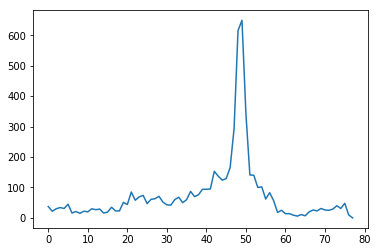

In [2]:
import numpy as np
import matplotlib.pyplot as plt


n_t_d = []
with open("province-biweek_with_delays.csv") as f:
    i = 0
    for line in f.readlines():
        if i > 0:
            n_t_d.append(line.replace("\n","").split(','))
        i+=1

n_t_d_1 = []

for elm in n_t_d:
    if elm[2] == "11":
        n_t_d_1.append(elm)


index_to_dates = {}
dates_to_index = {}
count = 0
for i in ["2014","2015","2016"]:
    for j in range(1,27):
        index_to_dates[count] = str(i)+str(j)
        dates_to_index[str(i)+str(j)] = count
        count +=1
        
reporting_matrix = np.zeros((26*3,26*3))

for elm in n_t_d_1:
    try:
        sick_date = elm[0]+elm[1]
        report_date = elm[-2] + elm[-1]
        cases = elm[3]
        reporting_matrix_row = dates_to_index[sick_date] 
        reporting_matrix_col =  dates_to_index[report_date] 
        reporting_matrix[reporting_matrix_row,reporting_matrix_col] = int(cases)
    except:
        pass
#np.set_printoptions(threshold=np.nan)

plt.plot(reporting_matrix.sum(axis=1))
plt.show()

78
0.042977530803083634


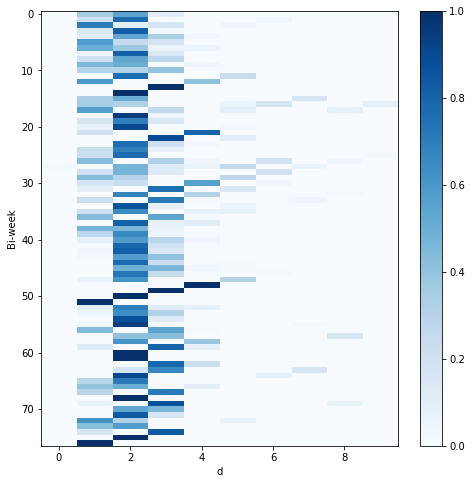

In [99]:
print (len(reporting_matrix))
D=10
n_t_d = np.zeros((len(reporting_matrix),D))

for i in range(len(reporting_matrix)):
    for j in range(i,i+D):
        try:
            n_t_d[i,j-i] = reporting_matrix[i][j]
        except:
            pass
n_t_d = n_t_d[:-1]
p_hat = []
from matplotlib.pyplot import cm

for i in range(len(n_t_d)):
    p_hat.append(n_t_d[i]/np.sum(n_t_d[i]))
    
p_hat = np.array(p_hat)
print (np.var(p_hat[:2]))
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide


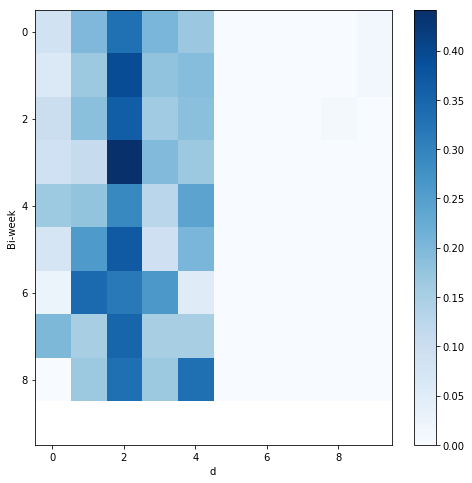

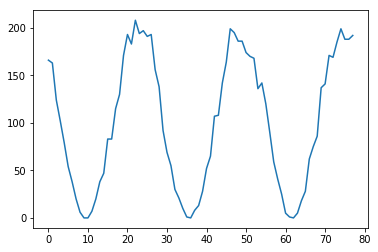

In [114]:
# list for holding simulated data, length 260
arr_list = np.zeros(260)
# iterate over season  
for s in range(10):
    #iterate over biweek per season
    for t in range(26):
        season_effect = np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
        e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
        arr_list[(s-1)*26+t] = np.random.poisson(10*e_y) 

# plot simulated data to make sure it looks like ID        
ts = arr_list[:100]

p_vec = np.random.dirichlet(np.append([50,100,200,100,100],np.ones(D-5)),size=1)[0]


sim_n_t_d = []
for i in range(78):
    tmp1 = np.random.multinomial(ts[i],p_vec,size=D).tolist()[0]
    sim_n_t_d.append(tmp1 )
sim_n_t_d = np.array(sim_n_t_d,dtype=np.float32)    
    
p_hat_sim = []
from matplotlib.pyplot import cm

for i in range(len(n_t_d)):
    p_hat_sim.append(sim_n_t_d[i]/np.sum(sim_n_t_d[i]))
    
    
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat_sim,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

plt.plot(sim_n_t_d.sum(axis=1))
plt.show()

In order to simulate delayed data we first randomly simualte the delay proportions from a dirichlet distribution

If the true delay distribution is given by 
$$p_0,...,p_{9} \sim Dirichlet(\alpha_1,...,\alpha_{10})$$

we can interpret $p_i$ as the percentage of cases that were delayed by $i$ days.

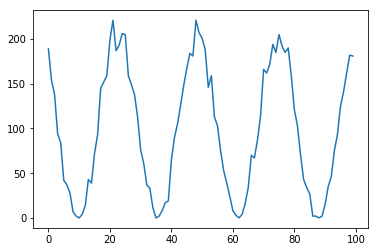

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


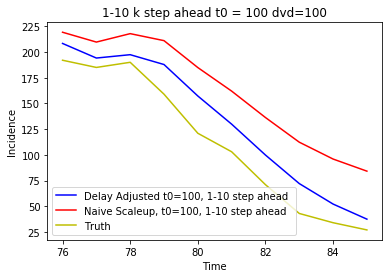

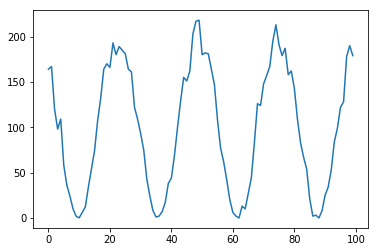

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


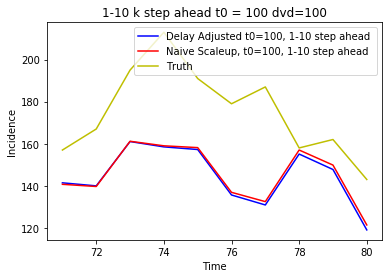

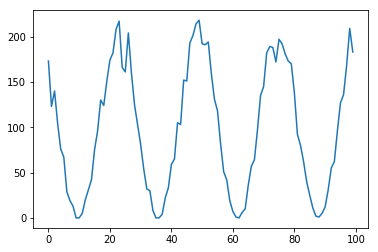

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


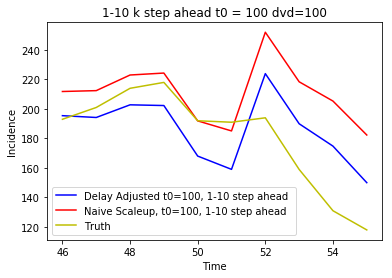

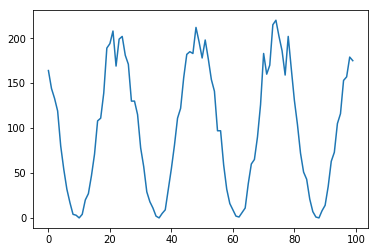

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


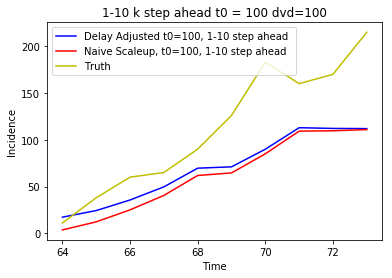

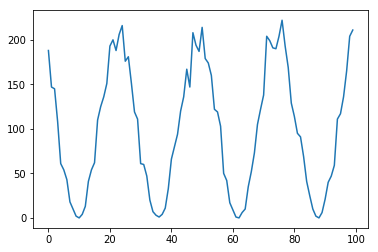

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


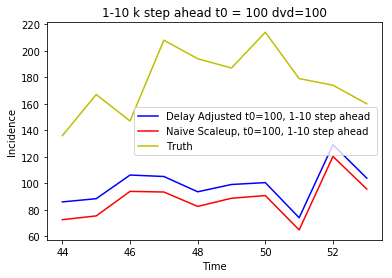

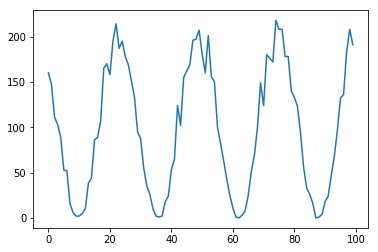

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


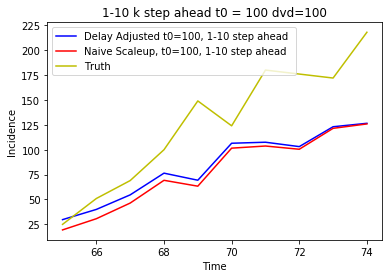

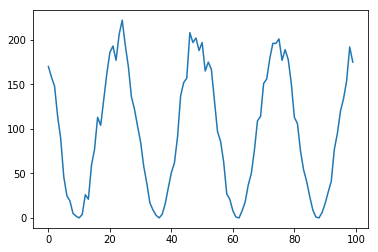

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


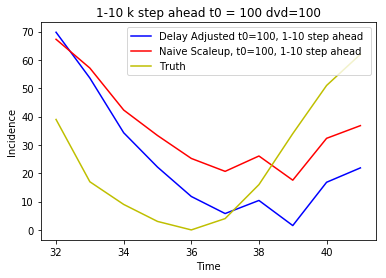

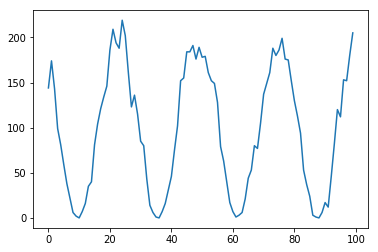

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


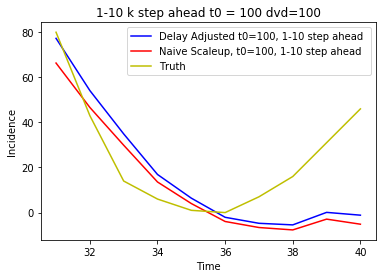

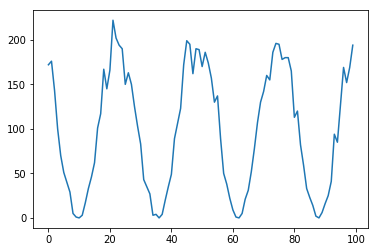

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


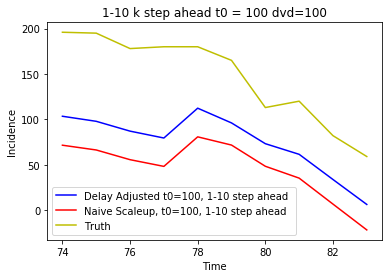

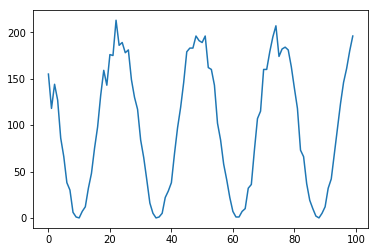

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


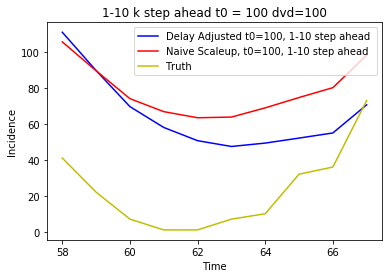

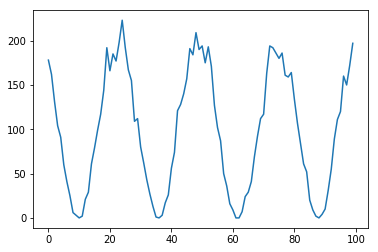

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


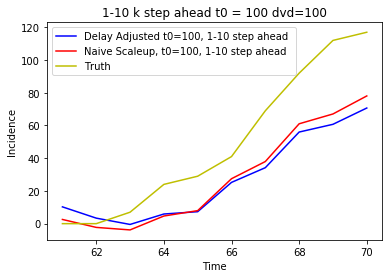

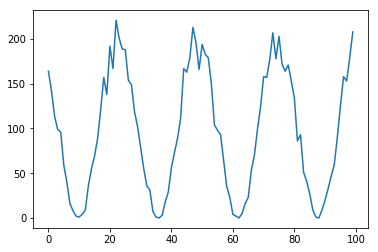

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


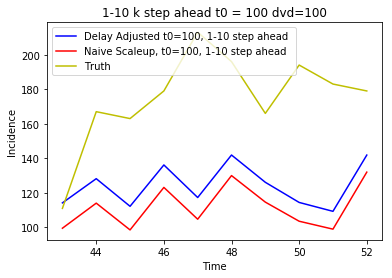

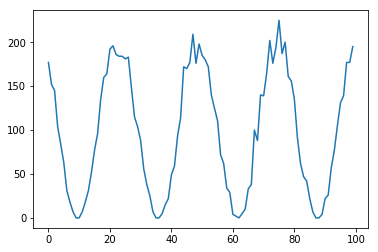

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


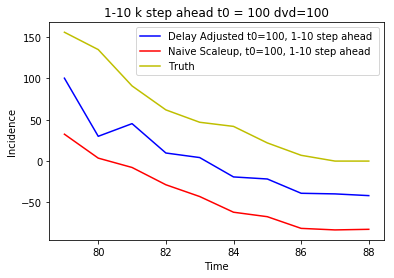

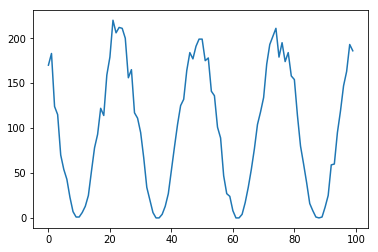

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


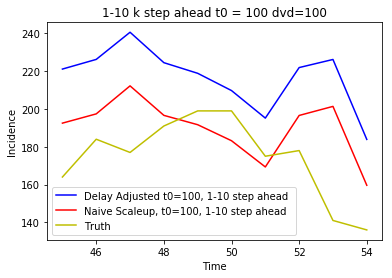

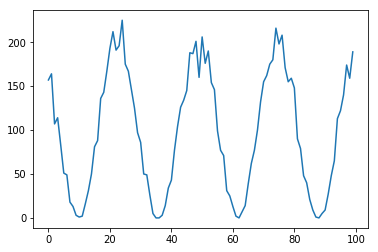

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


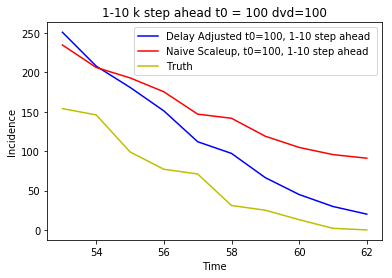

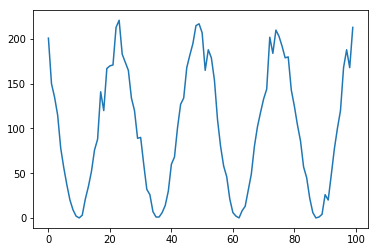

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


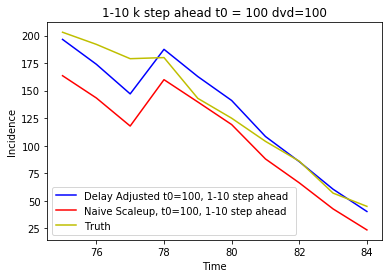

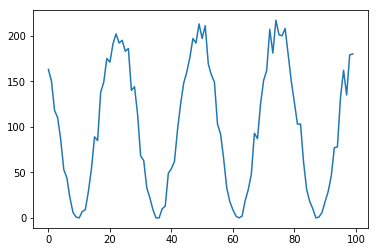

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


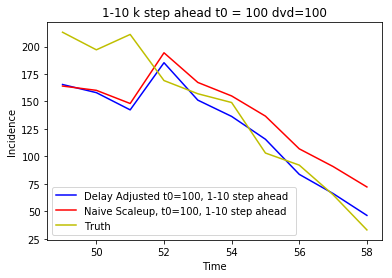

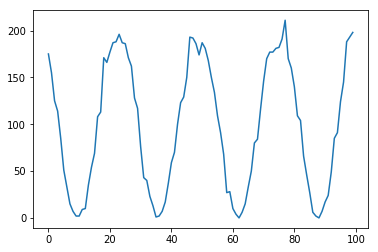

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


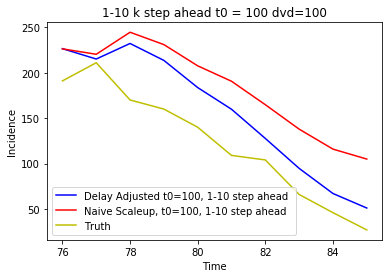

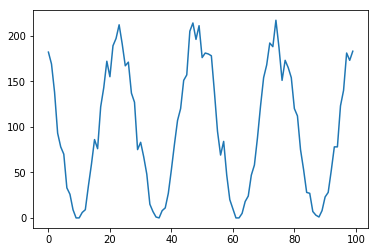

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


KeyboardInterrupt: 

In [148]:
from scipy.special import expit
variance_level_results = []

D = 10



for var in np.arange(100):
    rmse_vec = []
    arr_list = np.zeros(260)
    cutoff = np.random.randint(30,80)

# iterate over season  
    for s in range(10):
        #iterate over biweek per season
        for t in range(26):
            season_effect = np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
            e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
            arr_list[(s-1)*26+t] = np.random.poisson(10*e_y) 

    # plot simulated data to make sure it looks like ID        
    ts = arr_list[:100]
    
    p_vec = np.random.dirichlet(np.append([50,100,200,100,100],np.ones(D-5)),size=1)[0]


    sim_n_t_d = []
    for i in range(78):
        tmp1 = np.random.multinomial(ts[i],p_vec,size=D).tolist()[0]
        sim_n_t_d.append(tmp1 )
    sim_n_t_d = np.array(sim_n_t_d,dtype=np.float32)  

    plt.plot(ts)
    plt.show()
    train_n_t_d = sim_n_t_d

    for sim in range(1):
        
        # plot simulated data to make sure it looks like ID        

       


        k = np.array(train_n_t_d).shape[1 ]

        p_vec_noise = np.ones(k)

        for i in range(cutoff-D):
            p_vec_noise += train_n_t_d[i]

        p_vec_noise = p_vec_noise/np.sum(p_vec_noise)


        data_to_be_delayed = train_n_t_d[(cutoff-D):cutoff]
        count = len(data_to_be_delayed[0])
        folded_delayed_data = np.zeros(D)
        count =D
        for i in range(len(data_to_be_delayed)):
            folded_delayed_data[i] = np.sum(data_to_be_delayed[i][:count])
            count -=1

        delayed_data = np.append(ts[:(cutoff-D)],folded_delayed_data)
        n_t_d = data_to_be_delayed

        myDLM = dlm(ts[:(cutoff-D)])
        myDLM = myDLM + seasonality(26, name='26week', w=1.0)

        myDLM = myDLM + autoReg(degree=2, data=ts[:(cutoff-D)], name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (predictMean, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)


        n_t_inf_hat = predictMean
        num_mc_samples = 1000
        reweighted_trajectory = []
        from  scipy.stats import binom
        from  scipy.stats import norm
        count = D

        for t in range(len(n_t_inf_hat)):
            likelihood_previous = 1e-50
            likelihood_current = 1e-50
            prior_previous = 1e-50
            prior_current = 1e-50
            chain = []
            proposal_mean = 50
            ar = 0
            for s in range(num_mc_samples):

                proposal = np.random.normal(proposal_mean,10)

                prior_current = norm(n_t_inf_hat[t],np.sqrt(predictVar[t])/.1).pdf(proposal)

                likelihood_current = binom.pmf(folded_delayed_data[t],proposal,sum(p_vec_noise[:count]))
                alpha = likelihood_current*prior_current /(likelihood_previous*prior_previous)
                #print (alpha,likelihood_current*prior_current,likelihood_previous*prior_previous)

                if alpha >1 :           
                    likelihood_previous = likelihood_current
                    prior_previous = prior_current
                    proposal_mean = proposal
                    chain.append(proposal_mean)
                    ar += 1
                elif np.random.uniform(0,1) < alpha:
                    #print ("hello")
                    likelihood_previous = likelihood_current
                    prior_previous = prior_current
                    proposal_mean = proposal
                    chain.append(proposal_mean)
                    ar += 1
            if ar/(1.0*num_mc_samples) == 0.0:
                ret = 0
            elif np.isnan(np.mean(chain[200:])):
                ret = 0
            else:
                ret = np.mean(chain[200:])
            reweighted_trajectory.append(ret)


            count -=1 



        zero_through_90_data = delayed_data[:(cutoff-D)]
        ninety_through_100_data = delayed_data[(cutoff-D):]
        naive_training_data = ninety_through_100_data/np.flip(np.cumsum(p_vec_noise),axis=0)
        naive_training_data_final = np.append(zero_through_90_data,naive_training_data)

        myDLM = dlm(naive_training_data_final)
        myDLM = myDLM + seasonality(26, name='26day', w=1.0)

        myDLM = myDLM + autoReg(degree=2, data=naive_training_data_final, name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (scale_up_predictMean, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)


        new_training_data = np.nan_to_num(np.append(ts[:(cutoff-D)],reweighted_trajectory))
        myDLM = dlm(new_training_data)
        myDLM = myDLM + seasonality(26, name='26day', w=1.0)

        myDLM = myDLM + autoReg(degree=2, data=new_training_data, name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (predictMeanRetrain, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)

        truth = arr_list[cutoff:(cutoff+D)]

        from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
        myDLM = dlm(delayed_data)

        myDLM = myDLM + autoReg(degree=2, data=delayed_data, name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (predictMean, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)
        plt.plot(range(cutoff,cutoff+D),predictMeanRetrain,color='b')
        plt.plot(range(cutoff,cutoff+D),scale_up_predictMean,color='r')
        plt.plot(range(cutoff,cutoff+D),arr_list[cutoff:(cutoff+D)],color='y')
        plt.title("1-10 k step ahead t0 = 100 dvd=100")
        plt.legend(("Delay Adjusted t0=100, 1-10 step ahead ","Naive Scaleup, t0=100, 1-10 step ahead ","Truth"))
        plt.xlabel("Time")
        plt.ylabel("Incidence")

        plt.show()
        rmse_vec.append(mean_squared_error(predictMeanRetrain,truth)/mean_squared_error(scale_up_predictMean,truth))
        
        
    variance_level_results.append([rmse_vec])
        
        
        

In [95]:
# we only have a total of 78 data points so we need to choose a CV cutoff below 78-D
#cv_cutoff = 15
n_ahead = 10
rmse_table = []
for n_ahead in [1,5,10]:
    cv_table = []
    for cv_cutoff in [10,15,20,25,30,35]:
        # take a subset of completely reported data
        train_n_t_d = n_t_d[:cv_cutoff]

        #take a subset of completely reported data to apply delay mask to 
        mid_n_t_d = n_t_d[cv_cutoff:cv_cutoff+D]

        #testing data 
        test_n_t_d = n_t_d[cv_cutoff+D:(cv_cutoff+D+ n_ahead)]

        # uninformative dirichlet prior with all alpha=1
        # we know the analytical posterior will then be simply the counts of each delay bin
        # plus 1 

        p_vec_noise = np.ones(D)

        for i in range(len(train_n_t_d)):
            p_vec_noise += train_n_t_d[i]


        # Expected value of the dirichlet posterior
        p_vec_noise = p_vec_noise/np.sum(p_vec_noise)
        print (p_vec_noise)


        # apply the mast to the compltely observed data to turn it into
        # partially observerd data for CV
        count = D
        mid_n_t_d_masked = []
        for i in range(len(mid_n_t_d)):
            tmp = mid_n_t_d[i][:count].tolist()
            while len(tmp) < D:
                tmp.append(0)
            mid_n_t_d_masked.append(tmp)
            count -=1


        # sum of completely observed data up till CV cutoff    
        train_n_t_inf = np.sum(train_n_t_d,axis=1)

        ######
        # Predictions from model trained on completely observed data over the 
        # partially observed data range
        #####

        from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
        myDLM = dlm(train_n_t_inf)
        myDLM = myDLM + seasonality(26, name='26week', w=1.0)

        myDLM = myDLM + autoReg(degree=2, data=train_n_t_inf, name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (predictMean, predictVar) = myDLM.predictN(N=D, date=myDLM.n-1)
        n_t_inf_hat = predictMean
        #plt.plot(predictMean)
        #plt.plot(np.sum(mid_n_t_d,axis=1))
        #plt.legend(("Predicted","Truth"))
        #plt.show()

        ######
        # Predictions from model trained on completely observed data over the 
        # partially observed data range
        #####

        ## we initially set the variance scale factor to 1
        scale_factor=4

        ##########
        #  MCMC
        #
        ##########
        num_mc_samples = 1000
        reweighted_trajectory = []
        from  scipy.stats import binom
        from  scipy.stats import norm
        count = 10

        for t in range(len(n_t_inf_hat)):
            likelihood_previous = 1e-50
            likelihood_current = 1e-50
            prior_previous = 1e-50
            prior_current = 1e-50
            chain = []
            proposal_mean = 50
            ar = 0
            for s in range(num_mc_samples):

                proposal = np.random.normal(proposal_mean,10)

                prior_current = norm(n_t_inf_hat[t],np.sqrt(predictVar[t])/scale_factor).pdf(proposal)

                likelihood_current = binom.pmf(np.sum(mid_n_t_d_masked,axis=1)[t],proposal,sum(p_vec_noise[:count]))
                alpha = likelihood_current*prior_current /(likelihood_previous*prior_previous)
                #print (alpha,likelihood_current*prior_current,likelihood_previous*prior_previous)

                if alpha >1 :           
                    likelihood_previous = likelihood_current
                    prior_previous = prior_current
                    proposal_mean = proposal
                    chain.append(proposal_mean)
                    ar += 1
                elif np.random.uniform(0,1) < alpha:
                    #print ("hello")
                    likelihood_previous = likelihood_current
                    prior_previous = prior_current
                    proposal_mean = proposal
                    chain.append(proposal_mean)
                    ar += 1
            if ar/(1.0*num_mc_samples) == 0.0:
                ret = 0
            elif np.isnan(np.mean(chain[200:])):
                ret = 0
            else:
                ret = np.mean(chain[200:])
            reweighted_trajectory.append(ret)


            count -=1 


        ##########
        #  Get the partially observed
        #
        ##########
        mid_data = np.sum(mid_n_t_d_masked,axis=1)

        ######
        # Reweight the partially observed data 
        #  according to the cumulative proportions
        #####
        naive_training_data = mid_data/np.flip(np.cumsum(p_vec_noise),axis=0)

        naive_training_data = np.array(naive_training_data)

        reweighted_trajectory = np.array(reweighted_trajectory)
        #print (mid_n_t_d_masked)
        #print (np.flip(np.cumsum(p_vec_noise),axis=0))
        #print (naive_training_data)
        #print (reweighted_trajectory)
        #print (mid_n_t_d.sum(axis=1))

        ##########
        #  Predict by retraining on the naive model scale up
        #
        ##########


        myDLM = dlm(np.append(train_n_t_inf,naive_training_data))
        myDLM = myDLM + seasonality(26, name='26day', w=1.0)

        myDLM = myDLM + autoReg(degree=2, data=np.append(train_n_t_inf,naive_training_data), name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (scale_up_predictMean, predictVar) = myDLM.predictN(N=n_ahead, date=myDLM.n-1)


        ##########
        #  Predict by retraining the mixture model
        #
        ##########


        new_training_data = np.nan_to_num(np.append(train_n_t_inf,reweighted_trajectory))
        myDLM = dlm(new_training_data)
        myDLM = myDLM + seasonality(26, name='26day', w=1.0)

        myDLM = myDLM + autoReg(degree=2, data=new_training_data, name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (predictMeanRetrain, predictVar) = myDLM.predictN(N=n_ahead, date=myDLM.n-1)





        from sklearn.metrics import mean_squared_error
        truth = np.sum(test_n_t_d,axis=1)

        #plt.plot(predictMeanRetrain,color='b')
        #plt.plot(scale_up_predictMean,color='g')
        #plt.plot(truth,color='r')
        #plt.show()
        cv_table.append(mean_squared_error(predictMeanRetrain,truth)/mean_squared_error(scale_up_predictMean,truth))
    rmse_table.append(cv_table)


[0.0035461  0.33687943 0.4893617  0.13120567 0.0141844  0.0070922
 0.0070922  0.0035461  0.0035461  0.0035461 ]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


/Users/gcgibson/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gcgibson/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.00249377 0.29177057 0.45386534 0.17955112 0.03740648 0.02244389
 0.00498753 0.00249377 0.00249377 0.00249377]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.00182482 0.28467153 0.47080292 0.15693431 0.02737226 0.02372263
 0.01459854 0.00729927 0.00547445 0.00729927]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.



KeyboardInterrupt



In [94]:
print (rmse_table)
rmse_table_rounded = np.round(rmse_table,2).tolist()

NameError: name 'rmse_table' is not defined

In [251]:
from prettytable import PrettyTable

t = PrettyTable(['','t0 cutoff = 10',15,20,25,30,35])

t.add_row(['n_ahead = 5']+rmse_table_rounded[0])
t.add_row(['        = 10']+ rmse_table_rounded[1])
t.add_row(['        = 15']+ rmse_table_rounded[2])
print t


+--------------+----------------+------+------+------+------+------+
|              | cv cutoff = 10 |  15  |  20  |  25  |  30  |  35  |
+--------------+----------------+------+------+------+------+------+
| n_ahead = 5  |     123.68     | 1.31 | 1.02 | 0.45 | 0.01 | 8.37 |
|         = 10 |      2.41      | 1.08 | 0.88 | 0.26 | 0.42 | 0.14 |
|         = 15 |      1.34      | 1.09 | 0.82 | 0.33 | 0.2  | 0.03 |
+--------------+----------------+------+------+------+------+------+
